Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 108, 100)          45600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 108, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 108, 100)          80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 112)               11312     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 226       
Total params: 298,338
Trainable params: 298,338
Non-trainable params: 0
__________________________________________________

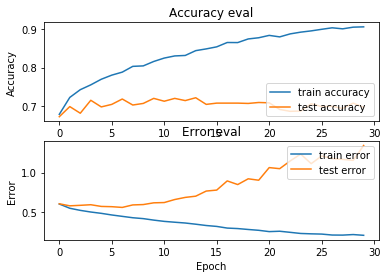

2046/2046 - 8s - loss: 1.2786 - accuracy: 0.7243

Test accuracy: 0.7243402


ValueError: Error when checking input: expected lstm_input to have 3 dimensions, but got array with shape (108, 13)

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "sick_sound.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # FOr rnn we do not require extra dimension. All u required is just 3 dimensions i.e. [total samples, mfcc vector, mfcc_coefficient] 

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generate RNN model

    :param input_shape (tuple): Shape of input set
    :return model: RNN model
    """

    # build network topology
    model = keras.Sequential()

    model.add(keras.layers.LSTM(100, input_shape = input_shape, return_sequences = True))
    model.add(keras.layers.LSTM(100, return_sequences = True))
    model.add(keras.layers.LSTM(100, return_sequences = True))
    model.add(keras.layers.LSTM(100))


    # output layer
    model.add(keras.layers.Dense(112, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(2, activation='softmax'))


    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    # X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    X = X[np.newaxis, ...] # array shape (130, 13, 1)


    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2])
    # Rnn takes input of 2 dims i.e. [130, 13] == [mfcc's vector, no of coefficients]
    model = build_model(input_shape)

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



# DOING PREDICTIONS

In [2]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    # X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    X = X[np.newaxis, ...] # array shape (130, 13, 1)


    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


X_to_predict = X_test[12]
y_to_predict = y_test[12]

predict(model, X_to_predict, y_to_predict)


Target: 0, Predicted label: [0]
